### <font color=red>Creates labels for marine heatwave events</font>

Marine heatwaves are defined using the *marineHeatWaves* module developed by [Eric Oliver](https://github.com/ecjoliver/marineHeatWaves)

**The following criteria are used to define marine heatwaves:**
- climatology: 1988-2017
- threshold: 90th percentile
- smoother: 31-days
- min duration: 5 days
- maximum gap between events = 2 days
***
Creator: Hillary Scannell 

Created: 07-23-2018

In [230]:
import numpy as np
import os, time, datetime
from datetime import date
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame, Series, concat
from marineHeatWaves import detect


**Load data time series.**
There are four time series of sea surface temperature (SST) contained in seperate netCDF files. The code below extracts the data from the data files using the indexing parameter *f*. Change the path (*fp*) to match the file directory on your machine and choose *f* values from 0 to 3 to change files. 

In [231]:
files = ['30n120w.nc', '30n140w.nc', '40n160w.nc', '50n140w.nc'] 
f = 3 # index to files  <- choose to analyze a different time series by changing f from 0 to 3

lat = files[f][0:2]
lon = files[f][3:6]
print('Location: '+lat+'ºN,'+lon+'ºS')

fp = '/Users/hscannell/Desktop/data/SST_daily_time_series/' # <- change this to your path
data_files = Dataset(fp+'sst_'+files[f]) # reading the netCDF file and creating a dataset
for c, value in enumerate(data_files.variables):
    print(data_files[value].name, data_files[value].dimensions, data_files[value].size) 
    
# SST (deg-C)   
SST = np.squeeze(data_files.variables['sst'][:])

# Time (days since)
f_time = data_files.variables['time'][:] # time is given in days since 1800-01-01 00:00:00
ref = datetime.date(1800, 1, 1).toordinal()
sst_time = ref+f_time # adjust time as days since 0000-01-01 00:00:00

# Dates (yyyy-mm-dd)
sst_dates = [date.fromordinal(tt.astype(int)) for tt in sst_time]
sst_dates = np.array(sst_dates)

# Create a python series
data = DataFrame(SST, columns=['SST'])
print(type(data), type(sst_time))
print(data.head())
print(sst_dates[0], sst_dates[-1])

Location: 50ºN,140ºS
lat ('lat',) 1
lon ('lon',) 1
sst ('time', 'lat', 'lon') 13433
time ('time',) 13433
<class 'pandas.core.frame.DataFrame'> <class 'numpy.ma.core.MaskedArray'>
         SST
0  14.740000
1  15.290000
2  12.349999
3  12.270000
4  12.570000
1981-09-01 2018-06-11


**Find marine heatwave in time series using *detect***

In [232]:
sst = np.array(data['SST'])
time = np.array(sst_time)

mhw, clim = detect(time, sst, climatologyPeriod=[1988, 2017], 
       pctile=90, windowHalfWidth=5, smoothPercentile=True, 
       smoothPercentileWidth=31, minDuration=6, 
       joinAcrossGaps=True, maxGap=2, maxPadLength=False, 
       coldSpells=False, alternateClimatology=False)

mhw_st = mhw['index_start'] # Start index of MHW
mhw_en = mhw['index_end'] # End index of MHW
sst_clim = clim['seas'] # seasonal climatology computed between 1988-2017
mhw_thres = clim['thresh'] # marine heatwave threshold computed as the 90th percentile from the seasonal climatology

In [233]:
print(len(mhw_st), len(mhw_en))
print('')
print(mhw_en)

print(np.array(mhw_en[0])-np.array(mhw_st[0]))

34 34

[894, 1910, 1968, 2951, 3730, 4433, 4504, 4545, 4738, 5844, 5857, 7785, 8363, 8613, 8677, 11668, 11704, 11812, 11986, 12013, 12044, 12095, 12173, 12240, 12292, 12318, 12380, 12411, 12485, 12561, 12654, 12678, 12777, 12809]
6


#### create labels, 1=mhw, 0=normal

In [234]:
mhw_label = sst*0

for i in range(0,len(mhw_st)):
    n = mhw_en[i]-mhw_st[i]
    mhw_label[mhw_st[i]:mhw_en[i]] = np.ones(n)

print('At this location there were {} MHWs between {} and {} \n'.format(len(mhw_st), sst_dates[0], sst_dates[-1]))   
    
dur = np.array(mhw_en)-np.array(mhw_st)
print('minimum event duration: \t{} days'.format(min(dur)))
print('maximum event duration: \t{} days \n'.format(max(dur)))

gap = np.array(mhw_st[1:])-np.array(mhw_en[0:-1])
print('minimum gap between events: \t{} days'.format(min(gap)))
print('maximum gap between events: \t{} days'.format(max(gap)))

At this location there were 34 MHWs between 1981-09-01 and 2018-06-11 

minimum event duration: 	5 days
maximum event duration: 	170 days 

minimum gap between events: 	4 days
maximum gap between events: 	2983 days


#### Plot labels for this time series

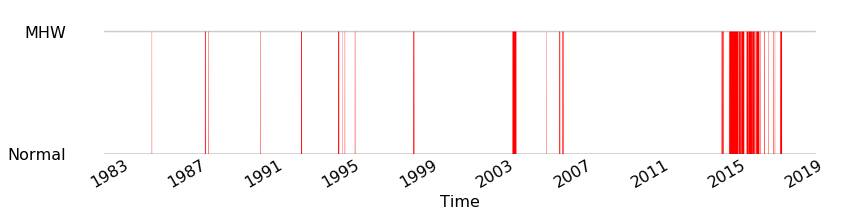

In [248]:
plt.rc('xtick', labelsize=16) 
plt.rc('ytick', labelsize=16)
plt.figure(figsize=(14,3)); ax = plt.subplot(111) 
plt.plot(sst_dates, np.ones(len(sst_dates)), 'k', alpha=0.2)
plt.plot(sst_dates, np.zeros(len(sst_dates)), 'k', alpha=0.2)
ax.fill_between(sst_dates, 0, mhw_label, facecolor='red')
plt.xlabel('Time', fontsize=16)
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left() 
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False) 
ax.spines["left"].set_visible(False) 
ax.spines["bottom"].set_visible(False) 
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.gcf().autofmt_xdate()
plt.yticks([0, 1], ['Normal', 'MHW']);  
plt.ylim(0, 1.2);

#### Save labels into a CSV file

In [236]:
print(type(sst_dates), type(mhw_label))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [237]:
import csv

fn = 'mhwLabels_'+files[f][:-3]+'.csv'
download_dir = '/Users/hscannell/Desktop/MHWpredict/data/Labels/'+fn 
print(download_dir)
#where you want the file to be downloaded to 

MyData = np.vstack((sst_dates, mhw_label))

myFile = open(download_dir, "w") 

with myFile:
    
    writer = csv.writer(myFile)

    writer.writerows(MyData)
     
print("Writing complete!")

/Users/hscannell/Desktop/MHWpredict/data/Labels/mhwLabels_50n140w.csv
Writing complete!
